# Basic Usage Example

In this example, we show the basic usage on a calibration/ground-truth example, in which we tracked a calibration wand with four GoPro Hero7 cameras.  

The cameras were aranged in a square with a side-length of 0.6 m. The 0.5 m calibration wand had two colored ends that we tracked throughout the synchronized footage, resulting in two four-view trajectories.  

In this notebook, we the triangulation of these multiple-view trajectories using the structure-from-motion scene reconstruction output from [COLMAP](http://colmap.github.io/).

We demonstrate a RMSE of 1.07 cm for tracking the calibration wand in this example.

In [1]:
import sys
sys.path.append('../..')

import MultiViewTracks as mvt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
scene = mvt.Scene(model_path='./data/sparse',
                  tracks_path='./data/tracks',
                  fisheye=False,
                  verbose=False)
scene.get_cameras()

First, interpolate the cameras to get complete camera paths, otherwise the tracks will be only triangulated at the reconstructed frames.

In [3]:
scene.interpolate_cameras()

Then, we

* triangulate the trajectory points that are observed from multiple views (and calculate respective reprojection errors),
* project the trajectory points only observed from exactly one view, the depth for this projection is interpolated from the triangulated trajectories,
* and combine the triangulated and projected trajectories.



In [4]:
scene.triangulate_multiview_tracks()
scene.get_reprojection_errors()
scene.project_singleview_tracks()
scene.get_tracks_3d()

We specify the measured real world distance and verify the selection of the correct camera ids.  
Cameras 1 and 3 were on one side of the camera array, so their distance is 0.6m.

In [5]:
camera_ids = [1, 3]
world_distance = 0.6

for camera_id in camera_ids:
    print(scene.cameras[camera_id])

Camera 1 | i_0_cut, 5821 views, with tracks
Camera 3 | m_0_cut, 5751 views, with tracks


Then, we scale the tracks and retrieve reconstruction errors.  
The reconstruction error is the per-frame difference of the reconstructed camera positions and the known real world distance.

In [6]:
reconstruction_errors = scene.scale(camera_ids, world_distance)

Finally, we rotate the tracks, so that x and y of the tracks match the first two principal components of the camera paths.  
For reconstructions in a flat environment, this ensures that the z component of the tracks is actually the height (or depth if filmed top-down) component.

In [7]:
scene.rotate()

Now we plot the multi-view triangulation (with reprojection errors), single-view projection and combined results for comparison.  
Note that since we scaled with a known real world distance, the axis scales represent meters.

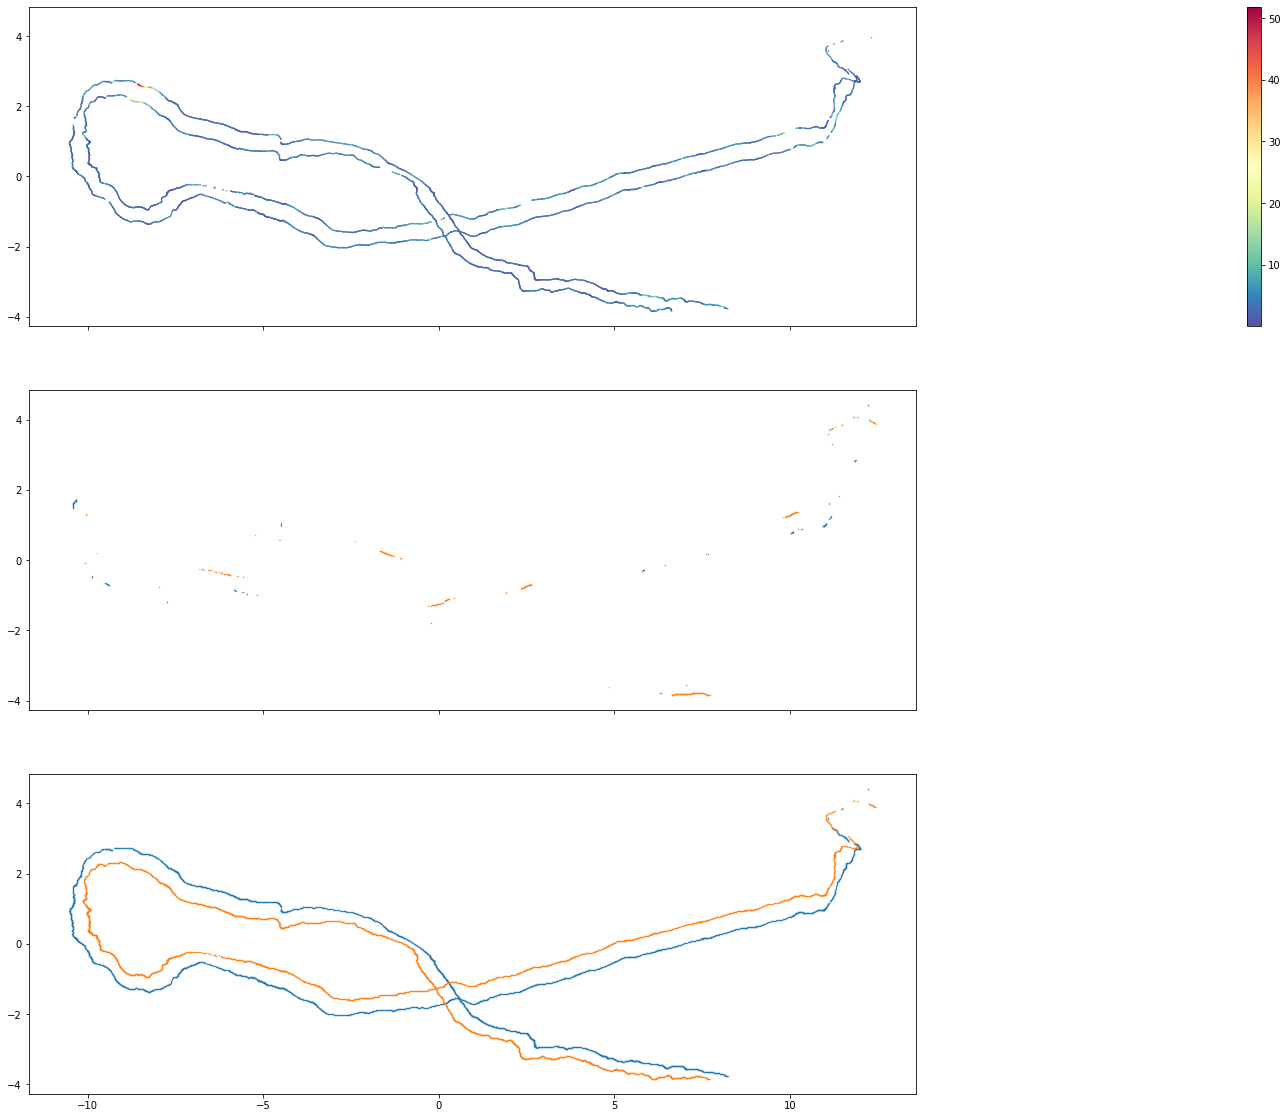

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(20, 20), sharey=True, sharex=True)
axes[0] = mvt.utils.plot_tracks_2d(scene.tracks_triangulated, ax=axes[0], show=False, size=0.1, style='errors')
axes[1] = mvt.utils.plot_tracks_2d(scene.tracks_projected, ax=axes[1], show=False, size=0.1)
axes[2] = mvt.utils.plot_tracks_2d(scene.tracks_3d, ax=axes[2], show=True, size=0.1);

The triangulated multiple-view tracks were already quite complete in this example and mainly have low reprojection errors, but the single-view tracks add some additional trajectory points. We can calculate the reconstruction errors of the calibration wand and compare it to the reconstruction errors of the cameras retrieved above.

# Calculating Reconstruction Errors

Now, we can calculate the calibration wand length and the corresponding reconstruction errors in each frame that has a 3d point for each of the ends.

In [9]:
import numpy as np

# real world distance of the calibration wand ends
world_distance = 0.5

# generate masks of the shared frame indices for both individuals (calibration wand ends)
shared = []
for i, j in zip(scene.tracks_3d['IDENTITIES'], scene.tracks_3d['IDENTITIES'][::-1]):
    shared.append(np.isin(scene.tracks_3d[str(i)]['FRAME_IDX'], scene.tracks_3d[str(j)]['FRAME_IDX']))
# retrieve the positions for each of the individuals, masked with the shared frames
pts_3d = []
for idx, i in enumerate(scene.tracks_3d['IDENTITIES']):
    pts_3d.append(np.transpose([scene.tracks_3d[str(i)]['X'][shared[idx]],
                                scene.tracks_3d[str(i)]['Y'][shared[idx]],
                                scene.tracks_3d[str(i)]['Z'][shared[idx]]]))
# calculate the distances and the errors
distances = np.sqrt(np.square(pts_3d[0] - pts_3d[1]).sum(axis=1))
errors = distances - world_distance

First, let's plot the error distribution.

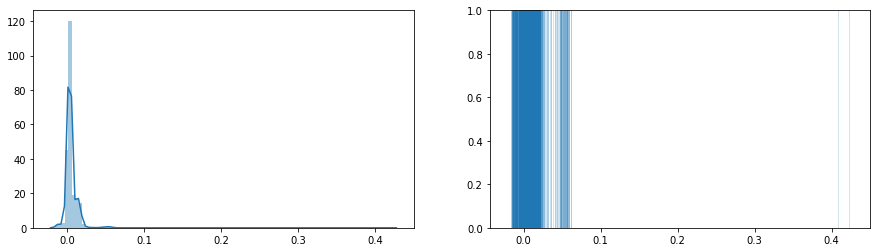

In [10]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15, 4))
sns.distplot(errors, bins=100, ax=axes[0])
sns.distplot(errors, bins=100, ax=axes[1], kde=False, hist=False, rug=True, rug_kws={'height': 1, 'alpha': 0.2})
axes[1].set_ylim((0, 1));

We can see that the majority of all errors are within a 5cm range around 0, which is quite accurate considering that the size of the reconstruction is > 20m.  
However, we can also see that the distribution has a long tail on the right, with some errors forming a peak at 6 cm and with two errors > 40 cm.  

For fine scale behavioral analyses, the larger errors should be generally avoided. So let's have a closer look at the reconstruction errors we retrieved above when scaling the scene. The scaling and rotating is only applied on the tracks, but not on the camera parameters, so we have to scale the camera paths separately using the same factor.

In [11]:
# specify the real world distance between the cameras
world_distance = 0.6

# retrieve the two cameras which were used for scaling from the scene
cameras = [scene.cameras[camera_ids[0]], scene.cameras[camera_ids[1]]]
# generate masks for each camera view indices in which both cameras are reconstructed
reconstructed = [np.isin(cameras[0].view_idx, cameras[1].view_idx),
                 np.isin(cameras[1].view_idx, cameras[0].view_idx)]
# retrieve the camera center paths for both cameras with applied masks
pts_3d = [np.array([cameras[0].projection_center(idx) for idx in cameras[0].view_idx])[reconstructed[0]],
          np.array([cameras[1].projection_center(idx) for idx in cameras[1].view_idx])[reconstructed[1]]]
# calculate the scale factor and the reconstruction errors
distances = np.sqrt(np.square(pts_3d[0] - pts_3d[1]).sum(axis=1))
scale = world_distance / distances.mean()
distances = distances * scale
# now calculate the reconstruction errors.
# these are same as returned by scene.scale, but we needed the camera paths for later visualization.
errors = distances - distances.mean()

Draw the same plot as for camera-to-camera distance error distribution.

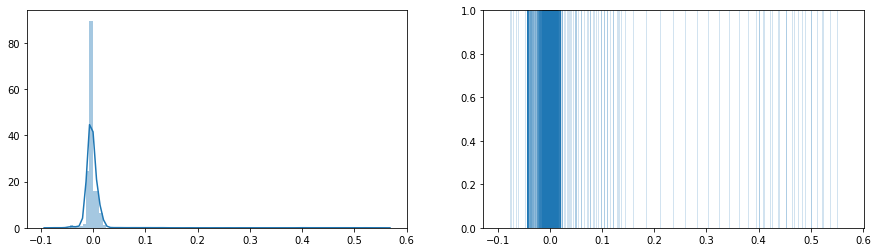

In [12]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15, 4))
sns.distplot(errors, bins=100, ax=axes[0])
sns.distplot(errors, bins=100, ax=axes[1], kde=False, hist=False, rug=True, rug_kws={'height': 1, 'alpha': 0.2})
axes[1].set_ylim((0, 1));

Again, we see that generally the camera-to-camera distances have a low error below 5 cm. The extended right tail of the error distribution is also visible here, with even more high errors. Let's plot the errors mapped onto the reconstructed camera paths.

Note that x and y are flipped for visualization (landscape plot), since the tracks rotation does not apply here. Although visually similar to the trajectory plots above, the plot below shows the camera paths of the two selected cameras and not the trajectories of the calibration wand ends.

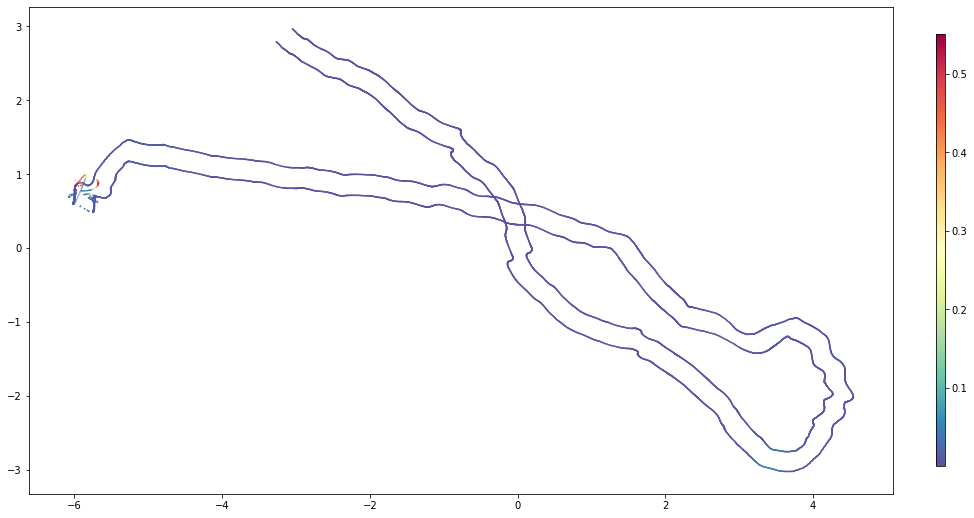

In [13]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0, 0, 1, 1])
for camera_path in pts_3d:
    mappable = ax.scatter(camera_path[:, 1], camera_path[:, 0], cmap=plt.get_cmap('Spectral_r'), c=np.absolute(errors), s=0.25)
ax.set_aspect('equal')
cax = fig.add_axes([1.05, 0.2, 0.01, 0.6])
fig.colorbar(mappable, cax=cax);

We can observe that the reconstrion errors are very low throughout the reconstruction, except at the end. So we have a look at the end of the videos, and can confirm that all cameras capture a diver, a lot of water and not so much of the static environment.

Basically, we forgot cut the synchronized videos to an appropriate length, and thus tried to reconstruct things that are not suitable for sfm reconstruction.

This is something we can easily fix by applying a conditional filter to the extrinsics before we initialize the cameras in the scene. 

In [14]:
scene = mvt.Scene(model_path='./data/sparse',
                  tracks_path='./data/tracks',
                  fisheye=False,
                  verbose=False)
scene.get_cameras()

Create and apply a filter that removes the last 15 seconds (or 450 frames) of the reconstruction. This is where the diver shows up and the trial is finished.

In [15]:
condition = scene.extrinsics['FRAME_IDX'] < scene.extrinsics['FRAME_IDX'].max() - 450
scene.extrinsics = {key: scene.extrinsics[key][condition] for key in scene.extrinsics}

And continue as above.

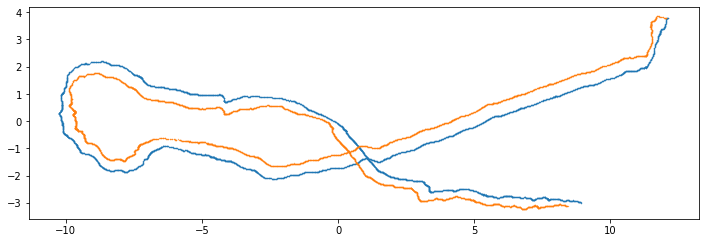

In [16]:
scene.get_cameras()
scene.interpolate_cameras()
scene.triangulate_multiview_tracks()
scene.get_reprojection_errors()
scene.project_singleview_tracks()
scene.get_tracks_3d()
camera_ids = [1, 3]
world_distance = 0.6
reconstruction_errors = scene.scale(camera_ids, world_distance)
scene.rotate()
mvt.utils.plot_tracks_2d(scene.tracks_3d, figsize=(12, 12), size=0.1, show=True);

We can see that in comparison to the tracks above, the weird-looking, final trajectory points are missing.

So let's plot the error distributions again and calculate root mean squared errors (RMSEs) for tracking the calibration wand and reconstructing the camera paths.

Calibration wand length reconstruction errors


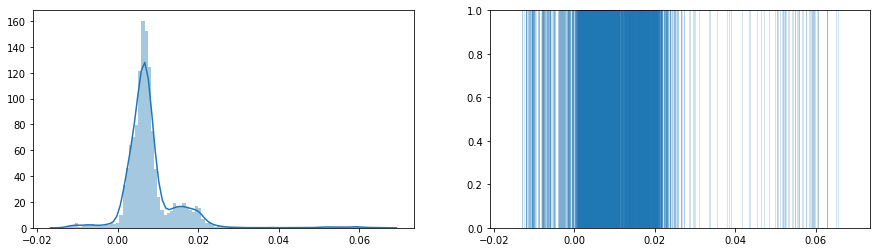

Camera-to-camera reconstruction errors


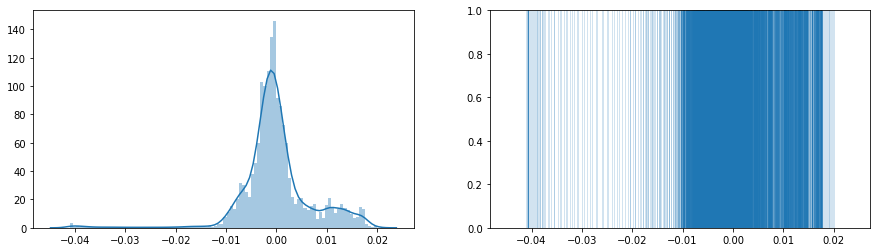

Visualizing the errors on top of the camera paths


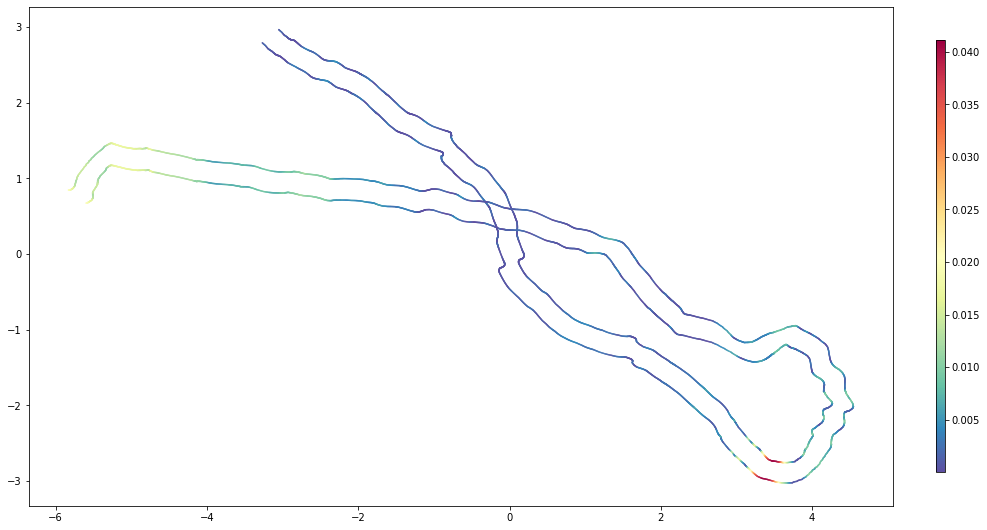

In [17]:
# real world distance of the calibration wand ends
world_distance = 0.5

# generate masks of the shared frame indices for both individuals (calibration wand ends)
shared = []
for i, j in zip(scene.tracks_3d['IDENTITIES'], scene.tracks_3d['IDENTITIES'][::-1]):
    shared.append(np.isin(scene.tracks_3d[str(i)]['FRAME_IDX'], scene.tracks_3d[str(j)]['FRAME_IDX']))
# retrieve the positions for each of the individuals, masked with the shared frames
pts_3d = []
for idx, i in enumerate(scene.tracks_3d['IDENTITIES']):
    pts_3d.append(np.transpose([scene.tracks_3d[str(i)]['X'][shared[idx]],
                                scene.tracks_3d[str(i)]['Y'][shared[idx]],
                                scene.tracks_3d[str(i)]['Z'][shared[idx]]]))
# calculate the distances and the errors
distances = np.sqrt(np.square(pts_3d[0] - pts_3d[1]).sum(axis=1))
errors_wand = distances - world_distance

# calculate the root mean squared error
rmse_wand = np.sqrt(np.square(errors_wand).mean())

print('Calibration wand length reconstruction errors')
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15, 4))
sns.distplot(errors_wand, bins=100, ax=axes[0])
sns.distplot(errors_wand, bins=100, ax=axes[1], kde=False, hist=False, rug=True, rug_kws={'height': 1, 'alpha': 0.2})
axes[1].set_ylim((0, 1));
plt.show()

# specify the real world distance between the cameras
world_distance = 0.6

# retrieve the two cameras which were used for scaling from the scene
cameras = [scene.cameras[camera_ids[0]], scene.cameras[camera_ids[1]]]
# generate masks for each camera view indices in which both cameras are reconstructed
reconstructed = [np.isin(cameras[0].view_idx, cameras[1].view_idx),
                 np.isin(cameras[1].view_idx, cameras[0].view_idx)]
# retrieve the camera center paths for both cameras with applied masks
pts_3d = [np.array([cameras[0].projection_center(idx) for idx in cameras[0].view_idx])[reconstructed[0]],
          np.array([cameras[1].projection_center(idx) for idx in cameras[1].view_idx])[reconstructed[1]]]
# calculate the scale factor and the reconstruction errors
distances = np.sqrt(np.square(pts_3d[0] - pts_3d[1]).sum(axis=1))
scale = world_distance / distances.mean()
distances = distances * scale
# now calculate the reconstruction errors.
# these are same as returned by scene.scale, but we needed the camera paths for later visualization.
errors_cameras = distances - distances.mean()

# calculate the root mean squared error
rmse_cameras = np.sqrt(np.square(errors_cameras).mean())

print('Camera-to-camera reconstruction errors')
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15, 4))
sns.distplot(errors_cameras, bins=100, ax=axes[0])
sns.distplot(errors_cameras, bins=100, ax=axes[1], kde=False, hist=False, rug=True, rug_kws={'height': 1, 'alpha': 0.2})
axes[1].set_ylim((0, 1));
plt.show()

print('Visualizing the errors on top of the camera paths')
fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0, 0, 1, 1])
for camera_path in pts_3d:
    mappable = ax.scatter(camera_path[:, 1], camera_path[:, 0], cmap=plt.get_cmap('Spectral_r'), c=np.absolute(errors_cameras), s=0.25)
ax.set_aspect('equal')
cax = fig.add_axes([1.05, 0.2, 0.01, 0.6])
fig.colorbar(mappable, cax=cax);

Note that again, x and y are flipped for visualization purposes and the plotted camera paths are not scaled to real-world scale.  
Also note the different scale of the colormap.

The RMSEs calculated above:

In [18]:
rmse_wand, rmse_cameras

(0.010682141792378272, 0.007042060594613508)

Removing the last frames reduced the error ranges to 2 cm for the majority calibration wand legth errors (with a maximum error <7 cm) and to 3 cm for the majority of camera-to-camera distance reconstruction errors (with a maximum error <5 cm).

In conclusion, incorrect pre-processing of the structure-from-motion input (not cutting the videos correctly) was the main reason of tracking errors in this example. When corrected, we have achieved a RMSE of 1.07 cm for tracking the calibration wand throughout approx. 25 x 10 m of a rocky, marine underwater environment.